# Data setup

In [1]:
import numpy as np
from scipy.optimize import minimize
from functools import partial

x = np.array([3])

In [2]:
from scipy.stats import norm, multivariate_normal

def sigma_fn(c, w_0=0.5, w_1=7):
    return w_0 ** 2 + (w_1 ** 2) * c

def sigma_dw_0(c, w_0, w_1):
    return 2 * w_0

def sigma_dw_1(c, w_0, w_1):
    return 2 * w_1 * c

num_samples = 10000

c = np.random.rand(num_samples)
sigma_2 = sigma_fn(c)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
y = x + eps

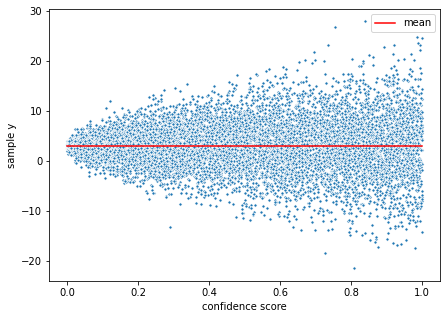

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(7, 5))
sns.scatterplot(c, y, s=10)
plt.xlabel('confidence score')
plt.ylabel('sample y')
plt.plot([0, 1], [y.mean(), y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

In [4]:
y[c < 0.1].std(), y[c > 0.9].std()

(1.6214580472660802, 7.106332136623163)

# 1.1: Frequentist approach

In [5]:
def l_dmu(mu, w_0, w_1):
    return ((y - mu) / sigma_fn(c, w_0, w_1)).sum()

def l_dw0(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_0(c, w_0, w_1)
            - (sigma_dw_0(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

def l_dw1(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_1(c, w_0, w_1)
            - (sigma_dw_1(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

In [6]:
def l_jac(params):
    mu, w_0, w_1 = params
    return - np.array([l_dmu(mu, w_0, w_1),
                     l_dw0(mu, w_0, w_1),
                     l_dw1(mu, w_0, w_1),
                    ])

In [7]:
def log_fn(params):
    mu = params[0]
    w_0 = params[1]
    w_1 = params[2]
    
    first = (y - mu) ** 2 / sigma_fn(c, w_0=w_0, w_1=w_1)
    second = np.log(sigma_fn(c, w_0=w_0, w_1=w_1))
    return first.sum() + second.sum()

minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG')

     fun: 39234.132562598155
     jac: array([-6.46634639e-05, -3.78489648e-03, -2.69532217e-03])
 message: 'Optimization terminated successfully.'
    nfev: 26
    nhev: 0
     nit: 24
    njev: 119
  status: 0
 success: True
       x: array([2.98422683, 0.49318295, 7.03861942])

In [8]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG').x

In [243]:
mu_mle, w0_mle, w1_mle

(2.984226832240184, 0.4931829455276706, 7.038619423659105)

# 1.2 Frequentist Regression

In [244]:
def sigma_fn_2(c, v_0=0.5, v_1=7):
    return v_0 ** 2 + (v_1 ** 2) * c

def sigma_2_dv_0(c, v_0, v_1):
    return 2 * v_0

def sigma_2_dv_1(c, v_0, v_1):
    return 2 * v_1 * c

def phi(x):
    return np.array([x ** 0, x, x ** 2]).squeeze()

num_samples = 100

x = np.random.randint(0, 101, size=num_samples)

c = np.zeros(num_samples)
#c = np.random.rand(num_samples)

w_0 = 13
w_1 = 0.9
w_2 = 0.02
v_0 = 0.01
v_1 = 0

w = np.array([w_0, w_1, w_2]).squeeze()

sigma_2 = sigma_fn_2(c, v_0=v_0, v_1=v_1)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
assert x.shape == (num_samples,)
y = w.T @ phi(x) + eps
assert y.shape == (num_samples,)

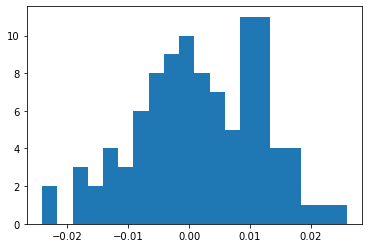

In [245]:
plt.hist(eps, bins=20);

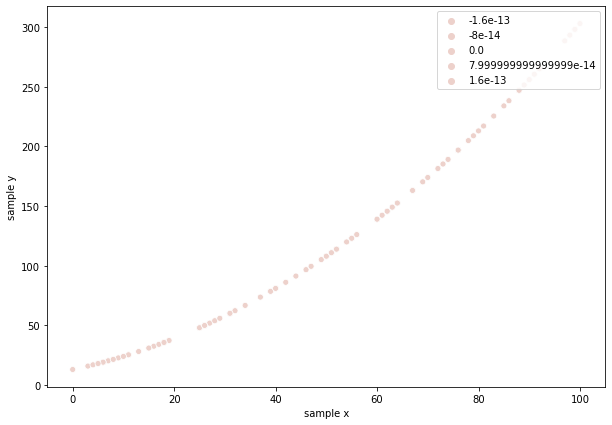

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10, 7))
sns.scatterplot(x,
                y,
                hue=c,
                )
plt.xlabel('sample x')
plt.ylabel('sample y')
plt.legend(loc='upper right');

In [247]:
def log_fn(params):
    w = params[0: 3]
    v = params[3: ]

    first = (w.T @ phi(x) - y) ** 2 / sigma_fn_2(c, *v)
    second = np.log(sigma_fn_2(c, *v))
    return - 0.5 * (first.sum() + second.sum())

In [248]:
F = lambda v: np.diag(sigma_fn_2(c, *v))
# F = lambda v: np.stack(np.ones((100,)) * x for x in sigma_fn_2(c, *v))
Phi = phi(x).T

In [238]:
# def l_deriv_w(w, v):
#     F_minus1 = np.linalg.inv(F(v) ** 0.5)
#     result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
#     #result = phi(x) @ ((w.T @ phi(x) - y) / sigma_fn_2(c, *v))
#     return - result

# grad_epsilon = 1e-6
# w = start[0: 3]
# v = start[3: ]
# w_plus = np.array([w_0 + grad_epsilon, w_1, w_2]).squeeze()
# w_minus = np.array([w_0 - grad_epsilon, w_1, w_2]).squeeze()
# v = np.array([v_0, v_1])
# approx_gradient = (log_fn(np.concatenate([w_plus, v]))
#                    - log_fn(np.concatenate([w_minus, v]))
#                    ) / (2 * grad_epsilon)
# distance = np.linalg.norm(l_deriv_w(w, v)[0] - approx_gradient.item())

# distance

In [262]:
def l_deriv_w(w, v):
    # F_minus1 = np.linalg.inv(F(v))
    # result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
    result = phi(x) @ ((w.T @ phi(x) - y) / sigma_fn_2(c, *v))
    return - result

def l_deriv_v0(w, v):
    first = (w @ phi(x) - y) * sigma_2_dv_0(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_0(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_deriv_v1(w, v):
    first = (w @ phi(x) - y) * sigma_2_dv_1(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_1(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_jac(params):
    w = params[0: 3]
    v = params[3: ]
    return - np.array([*l_deriv_w(w, v),
                       l_deriv_v0(w, v),
                       l_deriv_v1(w, v),
                       ])

In [263]:
start = np.array([14, 1, 0.03, 12, 75])

minimize(log_fn, start, jac=l_jac, method='Newton-CG')

     fun: -1153.4343750797393
     jac: array([ 2.74129711e+01,  2.00568711e+03,  1.58197537e+05,  1.20978381e+01,
       -0.00000000e+00])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 22
    nhev: 0
     nit: 0
    njev: 12
  status: 2
 success: False
       x: array([1.4e+01, 1.0e+00, 3.0e-02, 1.2e+01, 7.5e+01])

In [ ]:
# w_0 = 13
# w_1 = 0.9
# w_2 = 0.02
# v_0 = 11
# v_1 = 73

In [43]:
print(start)
end = start.copy()
for _ in range(10):
    end += 1e-4 * l_jac(end)
print(end)

[1.4e+01 1.0e+00 3.0e-02 1.2e+01 7.5e+01]
[3.36400576e+05 2.53402745e+07 2.03940146e+09 1.24469414e+04
 7.50000000e+01]


In [127]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, start, jac=l_jac, method='CG')
mu_mle, w0_mle, w1_mle

TypeError: sigma_2_dv_0() missing 2 required positional arguments: 'v_0' and 'v_1'

# 1.3 Bayesian approach